[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_what_if.ipynb)

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git



# Example: What-if scenarios
Create different scenarios on what may be the effect of a (future) change point
Non-hierarchical model using jhu data (no regions).

Runtime ~ 15 min

At the end we also show how to plot with German labels.


In [2]:
import datetime
import copy
import sys

In [3]:
import pymc3 as pm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

In [5]:
# limit the data range
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 5, 14)

In [6]:
# download data
jhu = cov19.data_retrieval.JHU(auto_download=True)
cum_cases = jhu.get_total(country="Germany", data_begin=bd, data_end=ed)
new_cases = jhu.get_new(country="Germany", data_begin=bd, data_end=ed)

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [7]:
# set model parameters
params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=28,
    diff_data_sim=16,
    N_population=83e6,
)

In [8]:
# change points like in the paper
cp_base = [
    # mild distancing
    dict(
        # account for new implementation where transients_day is centered, not begin
        pr_mean_date_transient=datetime.datetime(2020, 3, 10),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
    ),
    # strong distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 17),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
    ),
    # contact ban
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 24),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=0.5,
    ),
]



Scenarios for May 11, due to ~11 days delay, not evident in data yet
Add additional change points with reference to the previous values.

We use a value as reference that we inferred in a previous run (as of May 14)

In [9]:
ref = 0.10
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [10]:
# a: double the contacts (this only effectively applies apart from family)
cp_a = copy.deepcopy(cp_base)
cp_a.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=ref * 2,
        pr_sigma_lambda=0.3,
    ),
)

In [11]:
# b: back to pre-lockdown value
cp_b = copy.deepcopy(cp_base)
cp_b.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=0.15,
        pr_sigma_lambda=0.3,
    ),
)

In [12]:
# c: 20% decrease, ideal case, for instance if contact tracing is very effective
cp_c = copy.deepcopy(cp_base)
cp_c.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=ref - ref * 0.2,
        pr_sigma_lambda=0.3,
    ),
)

In [13]:
# we want to create multiple models with the different change points
def create_model(change_points, params_model):
    with cov19.Cov19Model(**params_model) as this_model:
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,
            name_lambda_t="lambda_t",
        )
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu)
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )
        new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")
        cov19.model.student_t_likelihood(cases=new_cases)
    return this_model

In [14]:
mod_a = create_model(cp_a, params_model)
mod_b = create_model(cp_b, params_model)
mod_c = create_model(cp_c, params_model)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [


## engage!
Increase tune and/or draws to get better statistics.


In [15]:
tr_a = pm.sample(model=mod_a, tune=50, draws=100, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b, tune=50, draws=100, init="advi+adapt_diag")
tr_c = pm.sample(model=mod_c, tune=50, draws=100, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 671.24:   9%|▉         | 18299/200000 [01:38<16:19, 185.48it/s]
Convergence achieved at 18300
INFO     [pymc3.variational.inference] Convergence achieved at 18300
Interrupted at 18,299 [9%]: Average Loss = 781.81
INFO     [pymc3.variational.inference] Interrupted at 18,299 [9%]: Average Loss = 781.81
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiproce

WARNING  [pymc3] The acceptance probability does not match the target. It is 0.9340118558217292, but should be close to 0.8. Try to increase the number of tuning steps.



## Plotting
### english


In [25]:
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True

In [ ]:
fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=cum_cases[0],
    forecast_label="Pessimistic",
    forecast_heading=r"$\bf Scenarios\!:$",
    add_more_later=True,
    color="tab:red",
)

In [27]:
fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Neutral",
    color="tab:orange",
)

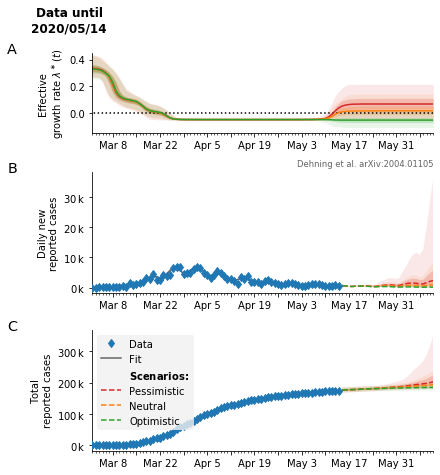

In [28]:
fig, axes = cov19.plot.timeseries_overview(
    mod_c,
    tr_c,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Optimistic",
    color="tab:green",
)
fig



### german


In [29]:
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True
cov19.plot.rcParams.locale = "de_DE"
cov19.plot.rcParams.date_format = "%-d. %b"

In [ ]:
fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=cum_cases[0],
    forecast_label="Pessimistisch",
    forecast_heading=r"$\bf Szenarien\!:$",
    add_more_later=True,
    color="tab:red",
)

In [31]:
fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Neutral",
    color="tab:orange",
)

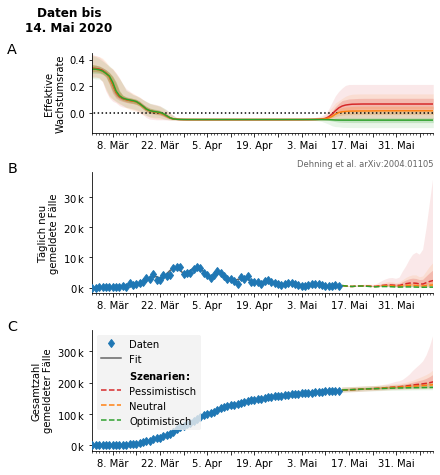

In [32]:
fig, axes = cov19.plot.timeseries_overview(
    mod_c,
    tr_c,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Optimistisch",
    color="tab:green",
)
fig